<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab12_SAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12: Soft Actor Critic

Train a Soft Actor-Critic (SAC) agent on HalfCheetah-v4,
track its learning curve, and compare the result with your previous RL algorithm.

We will learn to use the **stable_baselines3** library


## To start
Run the following code that solves **the Pendulum problem**

In [ ]:
# Install dependencies
%pip install "stable-baselines3[extra]" "gymnasium[classic_control]"

In [7]:
%pip install -U tqdm ipywidgets

Note: you may need to restart the kernel to use updated packages.


The following code trains a full SAC agent — with two critics, entropy tuning, and replay buffer — out of the box

In [1]:
import gymnasium as gym
from stable_baselines3 import SAC

# Create environment
env = gym.make("Pendulum-v1")

# Create SAC model
model = SAC("MlpPolicy", env, verbose=1)

# Train the agent with N time steps
N = 4000
model.learn(total_timesteps=N)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -1.6e+03 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 200      |
|    time_elapsed    | 3        |
|    total_timesteps | 800      |
| train/             |          |
|    actor_loss      | 27.3     |
|    critic_loss     | 0.227    |
|    ent_coef        | 0.813    |
|    ent_coef_loss   | -0.332   |
|    learning_rate   | 0.0003   |
|    n_updates       | 699      |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.56e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 194       |
|    time_elapsed    | 8         |
|    total_timesteps | 1600      |
| train/    

# Visualize the result

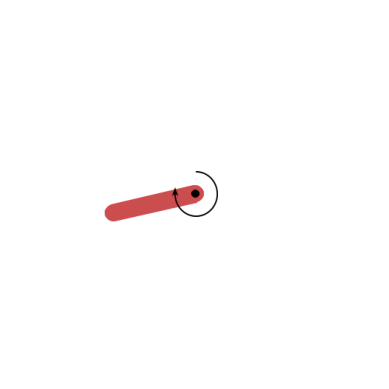

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

env = gym.make("Pendulum-v1", render_mode="rgb_array")
obs, _ = env.reset()

fig, ax = plt.subplots()
frame = env.render()
img = ax.imshow(frame)
plt.axis("off")

for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    frame = env.render()
    img.set_data(frame)

    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)

    if done or truncated:
        obs, _ = env.reset()

env.close()
plt.close()


## Exercise 1: Soft Actor-Critic on HalfCheetah
**Goal:**
Adapt the existing Soft Actor-Critic (SAC) implementation from the Pendulum-v1 environment to train and evaluate a SAC agent on the more challenging HalfCheetah-v4 task.

### Instructions

1. Adapt your code: Modify your previous SAC implementation so that it runs on the HalfCheetah-v4 environment from MuJoCo.

2. Reward Logger:
Implement a custom RewardLogger callback to record episode rewards during training (you will have to search online about how to create a class for logger).
After training, use the logged data to plot the learning curve (episode reward vs. timesteps).

3. Experimentation:
    * Compare the performance of SAC on HalfCheetah-v4 with your previous algorithm.
    * Adjust the entropy temperature parameter (ent_coef or target_entropy) and observe how this affects: Exploration behavior, Convergence speed, and Final performance.

Answer the following questions
1. Did SAC reach a higher average reward or converge faster than your previous method?

2. How did changing the temperature for entropy affect the performance and stability of learning?

3. Describe any differences you observed in exploration or motion behavior of the agent.


### Deliverables

* Python notebook or script containing:
    * The adapted SAC training code
    * The RewardLogger implementation
    * Learning curve plots for SAC and your previous algorithm
    * Comparison of different entropy temperature settings

* The answer of the questions above

In [4]:
%pip install gymnasium[mujoco]

Note: you may need to restart the kernel to use updated packages.


# Training

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

N_STEPS = 4_000_000

LOG_PATH = "sac_halfcheetah_rewards.npz"   # file where we store the curves


# -------- 1) Custom reward logger callback that also SAVES TO DISK --------
class RewardLoggerCallback(BaseCallback):
    """
    Logs episode rewards during training and saves them to disk at the end.

    Attributes saved:
      - episode_rewards: list of total episode rewards
      - episode_timesteps: list of global timesteps when each episode ended
    """
    def __init__(self, log_path: str, verbose: int = 0):
        super().__init__(verbose)
        self.log_path = log_path
        self.episode_rewards = []
        self.episode_timesteps = []

    def _on_training_start(self) -> None:
        n_envs = self.training_env.num_envs
        self._current_rewards = np.zeros(n_envs, dtype=np.float64)

    def _on_step(self) -> bool:
        rewards = self.locals["rewards"]   # shape (n_envs,)
        dones   = self.locals["dones"]     # shape (n_envs,)

        # accumulate rewards
        self._current_rewards += rewards

        # when an env is done, log and reset its accumulator
        for i, done in enumerate(dones):
            if done:
                self.episode_rewards.append(self._current_rewards[i])
                self.episode_timesteps.append(self.num_timesteps)
                self._current_rewards[i] = 0.0

        return True  # continue training

    def _on_training_end(self) -> None:
        """Save logs to disk when training is finished."""
        ep_rew = np.array(self.episode_rewards, dtype=np.float32)
        ep_ts  = np.array(self.episode_timesteps, dtype=np.int64)
        np.savez(self.log_path,
                 episode_rewards=ep_rew,
                 episode_timesteps=ep_ts)
        if self.verbose > 0:
            print(f"[RewardLoggerCallback] Saved logs to {self.log_path}")


# -------- 2) Train SAC with the callback --------
env = gym.make("HalfCheetah-v5")

model = SAC("MlpPolicy", env, ent_coef=0.3, verbose=1)

reward_logger = RewardLoggerCallback(log_path=LOG_PATH, verbose=1)

model.learn(total_timesteps=N_STEPS,
            callback=reward_logger,
            progress_bar=True)

# Optionally save the agent
model.save(f"SAC_T_03_{N_STEPS}")

env.close()


# -------- 3) Plot learning curve NOW (using the in-memory logger) --------
plt.figure(figsize=(12, 8))
plt.plot(reward_logger.episode_timesteps,
         reward_logger.episode_rewards,
         marker="o", linestyle="-", linewidth=1)

plt.xlabel("Timesteps")
plt.ylabel("Episode reward")
plt.title("SAC on HalfCheetah-v5 - Episode reward vs. timesteps")
plt.grid(True)
plt.tight_layout()
plt.show()


# PLOT TO COMPARE

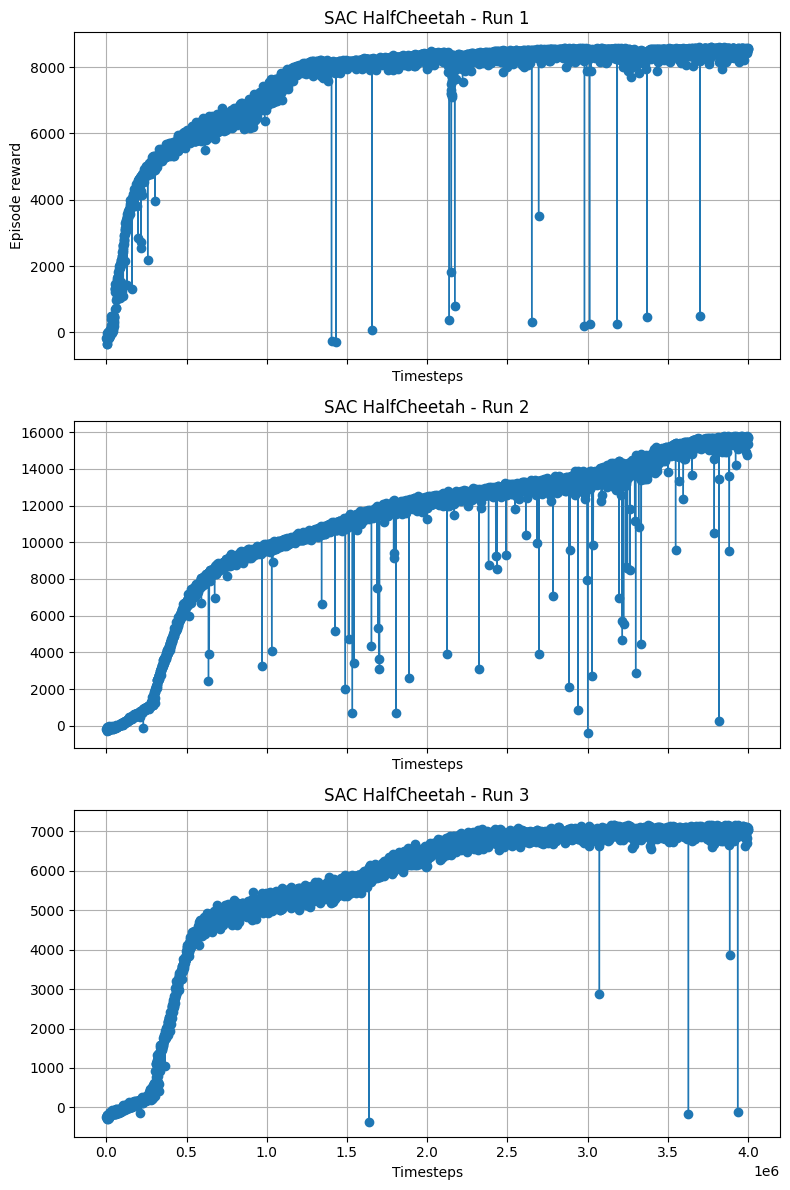

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# List your log files here
LOG_PATHS = [
    "sac_halfcheetah_rewards_4M_01.npz",
    "sac_halfcheetah_rewards_4M_03.npz",
    "sac_halfcheetah_rewards_4M_05.npz",
]

# Titles for each subplot (same order as LOG_PATHS)
TITLES = [
    "SAC HalfCheetah - Run 1",
    "SAC HalfCheetah - Run 2",
    "SAC HalfCheetah - Run 3",
]

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)


for ax, log_path, title in zip(axes, LOG_PATHS, TITLES):
    data = np.load(log_path)
    episode_rewards   = data["episode_rewards"]
    episode_timesteps = data["episode_timesteps"]

    ax.plot(episode_timesteps, episode_rewards,
            marker="o", linestyle="-", linewidth=1)

    ax.set_title(title)
    ax.set_xlabel("Timesteps")
    ax.grid(True)

# Only need one shared y-label
axes[0].set_ylabel("Episode reward")

plt.tight_layout()
plt.show()


# TEST

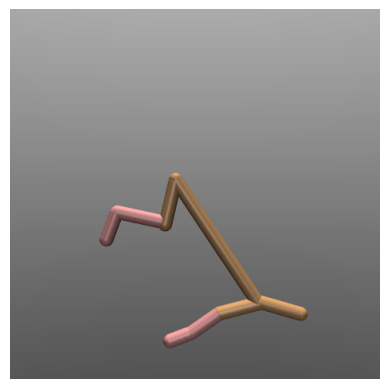

In [18]:
#import gym
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from stable_baselines3 import SAC   # or PPO, TD3, etc.

# === Choose which model to test ===
MODEL_PATH = "SAC_T_05_4000000.zip"   # <- change this to pick another model

# Create env (must match training env)
env = gym.make("HalfCheetah-v5", render_mode="rgb_array")

# Load the model
model = SAC.load(MODEL_PATH)

obs, _ = env.reset()

fig, ax = plt.subplots()
frame = env.render()
img = ax.imshow(frame)
plt.axis("off")

for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    frame = env.render()
    img.set_data(frame)

    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)

    if done or truncated:
        obs, _ = env.reset()

env.close()
plt.close()


# PART 3

Answer the following questions

## Did SAC reach a higher average reward or converge faster than your previous method?
If we compare SAC with Q-Learning or MBRL stills a slow method and take to much time for leaning and converge. However if SAC is compare with methods like PPO, SAC is faster. 

## How did changing the temperature for entropy affect the performance and stability of learning?
When I used a higher entropy temperature, the agent explored more but learned slower and the rewards were less stable; when I used a lower entropy temperature, the agent learned faster at first but often got it doest no find the optimal solution; using `ent_coef="auto"` gave the best balance, with enough exploration and more stable learning.

## Describe any differences you observed in exploration or motion behavior of the agent.
The main difference is due to the reward just move forward, for PPO as well as SAC, sometimes the agent just move forward but upside down. Thus the system requires a larger number of episodes for training. 